# Goals

#### Predict Gender and age in given groups based on the datasets provided 
These datasets come in csv files connected by different identification keys. 

# Understand the data
This is crucial! There are basic explanations on the competitions [website](https://www.kaggle.com/c/talkingdata-mobile-user-demographics/data). Here is the data connection diagramm given:
![Data diagramm](data_tree.png)

We also already now that the company names are provided in chinese, which is not particularly helpful. Then, we see that the apps already are categorised, which is handy. However, doubt is present that the variable can be used out-of-the box.

In [286]:
# Set input dir
import sys
sys.path.append("/home/mschlupp/pythonTools")
tmp = %pwd
files_dir = tmp + "/files" 

In [180]:
# perform imports so that we can use single cells w/o worrying about imports
import pandas as pd
from pandas import DataFrame as df
import IPython as ip

import seaborn as sns
sns.set(color_codes=True)

%matplotlib inline
import matplotlib.pyplot as plt

#### Load some nice colors from [my github](https://github.com/mschlupp/pythonTools/tree/master/plotting)
Then delete a few lines of the original file to make the code a bit leaner.

In [56]:
# %load '/home/mschlupp/pythonTools/plotting/nice_colors.py'

'''
Color dictionaries from 
http://tableaufriction.blogspot.de/2012/11/finally-you-can-use-tableau-data-colors.html
'''

Tableau10_Medium = { 
	"blue"   : (114/255.,158/255.,206/255.),
	"orange" : (255/255.,158/255.,74/255.),
	"green"  : (103/255.,191/255.,92/255.),
	"red"    : (237/255.,102/255.,93/255.),
	"purple" : (173/255.,139/255.,201/255.),
	"brown"  : (168/255.,120/255.,110/255.),
	"pink"   : (237/255.,151/255.,202/255.),
	"gray"   : (162/255.,162/255.,162/255.),
	"olive"  : (205/255.,204/255.,93/255.),
	"cyan"   : (109/255.,204/255.,218/255.)
}

ColorBlind10 = {
	"azure"        : (0./255.,107./255.,164/255.),
	"orange"       : (255./255.,128./255.,14/255.),
	"grey_medium"  : (171./255.,171./255.,171/255.),
	"grey_dark"    : (89./255.,89./255.,89/255.),
	"blue_medium"  : (95./255.,158./255.,209/255.),
	"orange_dark"  : (200./255.,82./255.,0/255.),
	"grey"         : (137./255.,137./255.,137/255.),
	"blue_light"   : (162./255.,200./255.,236/255.),
	"orange_light" : (255./255.,188./255.,121/255.),
	"grey_light"   : (207./255.,207./255.,207/255.)

}


In [2]:
# We can have a look what's in the files directory
%ls files/

app_events.csv  gender_age_test.csv   phone_brand_device_model_engl.csv
app_labels.csv  gender_age_train.csv  sample_submission.csv
events.csv      label_categories.csv


In [35]:
ga_test = pd.read_csv(files_dir+"/gender_age_test.csv")
ga_train = pd.read_csv(files_dir+"/gender_age_train.csv")

In [33]:
ip.display.display(ga_test.head(5),ga_test.describe())
# simple device ids. to predict gender and age, we need to combine the devide ids with our features finally used to predict the category

,device_id
0,1002079943728939269
1,-1547860181818787117
2,7374582448058474277
3,-6220210354783429585
4,-5893464122623104785


,device_id
count,1.120710e+05
mean,-2.367461e+16
std,5.331855e+18
min,-9.223322e+18
25%,-4.661036e+18
50%,-3.107321e+16
75%,4.581985e+18
max,9.223069e+18


#### In total we have 112,071 devices to predict

In [35]:
ip.display.display(ga_train.head(5), ga_train.describe())

,device_id,gender,age,group
0,-8076087639492063270,M,35,M32-38
1,-2897161552818060146,M,35,M32-38
2,-8260683887967679142,M,35,M32-38
3,-4938849341048082022,M,30,M29-31
4,245133531816851882,M,30,M29-31


,device_id,age
count,7.464500e+04,74645.000000
mean,-7.491354e+14,31.410342
std,5.327150e+18,9.868735
min,-9.223067e+18,1.000000
25%,-4.617367e+18,25.000000
50%,-1.841362e+16,29.000000
75%,4.636656e+18,36.000000
max,9.222849e+18,96.000000


#### Unfortunately we have less data to train on, 'only' 74,645 devices. 
We have a rich data structure to explore, I guess we'll end up with k-folding.

In [64]:
g = ga_train['gender']

In [65]:
g.value_counts()

M    47904
F    26741
Name: gender, dtype: int64

(-1.0081850964587609, 1.0152298683632917, -1.0128984268823065, 1.0)

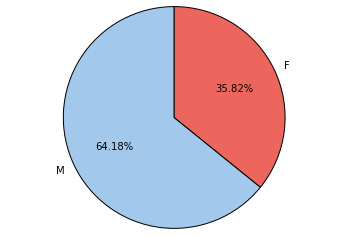

In [73]:
plt.pie(g.value_counts(),colors=[ColorBlind10['blue_light'],Tableau10_Medium['red']],
        labels=g.value_counts().index, autopct='%2.2f%%', startangle=90)
plt.axis('equal')

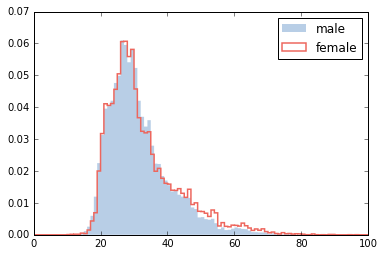

In [79]:
plt.hist(ga_train.age[ga_train.gender=='M'],100,normed=True
         ,color=Tableau10_Medium['blue'],histtype='stepfilled', alpha=0.5
         ,range=(0,100), label='male', linewidth=0); # colon to prevent numeric output prior to plot
plt.hist(ga_train.age[ga_train.gender=='F'],100,normed=True
         ,color=Tableau10_Medium['red'],histtype='step'
         ,range=(0,100),label='female',linewidth=1.5);
plt.legend();

Data comes from an SDK, explicit agreement of data use needed. Bias towards male data might be explained by that. Still the age distributions look fairly similar, no need to worry about age biases to this point.
How does the distribution of the training data looks like in the target variable?

In [109]:
ga_train.group[ga_train.gender=="F"].unique()

array(['F24-26', 'F33-42', 'F27-28', 'F43+', 'F23-', 'F29-32'], dtype=object)

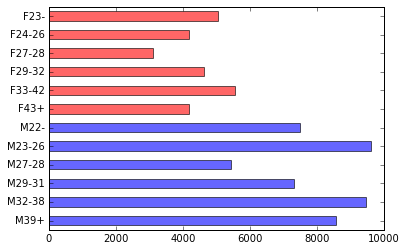

In [80]:
# ok try to color female and male differently
colors = 'r'*len(ga_train.group[ga_train.gender=='F'].unique()) + 'b'*len(ga_train.group[ga_train.gender=='M'].unique())
# this only works if the female and male categories are completely separated. They are not...
# next try, construct color string from indices
# we could use user defined colors, then we would need to create a list of colors
a = ga_train.group.value_counts().sort_index(ascending=False)
colors=''
for x in a.index :
    colors+= 'r' if x.startswith('F') else 'b' 

a.plot.barh(color=colors,alpha=0.6); # works fine.

There are different number of customers in each category. When we understand we data a bit better, we can think of applying a deep learning method to predict the categories as follows: a) predict male or female, b) predict age of customer. 
First we need to continue with the data exploration.

In [127]:
# I forgot about the datasets...
%ls files/

app_events.csv  gender_age_test.csv   phone_brand_device_model.csv
app_labels.csv  gender_age_train.csv  sample_submission.csv
events.csv      label_categories.csv


In [114]:
# The next datasets probably easy to merge with the device id are the phone, brand and device information
# the brand names have been translated, as good as possible:
# phone_brand_device_model_engl.csv --- however, that drops ~ 40 brands.
# so let's use the chinese names for now.
hardware = pd.read_csv(files_dir+"/phone_brand_device_model.csv")#,index_col=0)
hardware.head(2)

,device_id,phone_brand,device_model
0,-8890648629457979026,小米,红米
1,1277779817574759137,小米,MI 2


In [115]:
def showUniques(df):
    print("Number of rows: ", len(df))
    print("Number of unique values per column: ")
    for col in df.columns:
        print("Column {}: ".format(col), df[col].nunique())

In [116]:
showUniques(hardware)

Number of rows:  187245
Number of columns:  3
Number of unique values per column: 
Column device_id:  186716
Column phone_brand:  131
Column device_model:  1599


In [75]:
hardware.isnull().sum()
len(hardware.device_id)-hardware.device_id.nunique()

529

Ok, there are 529 device_ids occuring more than once.
Let's find about the doubles.

In [157]:
s = hardware.groupby('device_id')
tab = s.count()
tab.sort_values("phone_brand",ascending=False).head(3)

,phone_brand,device_model
device_id,,
1877775838486905855,2,2
6974738683971424976,2,2
-3389605147156464826,2,2


There are device_id that have more than one phone. We you check if a customer has more than one phone or if this is just a mistake.

In [156]:
hardware[hardware.device_id==1877775838486905855]

,device_id,phone_brand,device_model
10782,1877775838486905855,vivo,Y13
22625,1877775838486905855,vivo,Y13


For the first entry this seems to be a mistake, as we can assume that a customer does not buy a phone twice (does it even mean this?). Well, or the customer is old and does not want to learn a new interface.

In [186]:
# get the set of device_ids that have more then one phone
tab = tab[tab.phone_brand>1]
print('length: ', len(tab), 'mean: ', tab.phone_brand.mean())
ga_train.head(2)

length:  529 mean:  2.0


,device_id,gender,age,group,isTrain
0,-8076087639492063270,M,35,M32-38,1
1,-2897161552818060146,M,35,M32-38,1


Perfect, we have all the decice_ids with more than one entry.
We can test if these device ids are correlated with age.

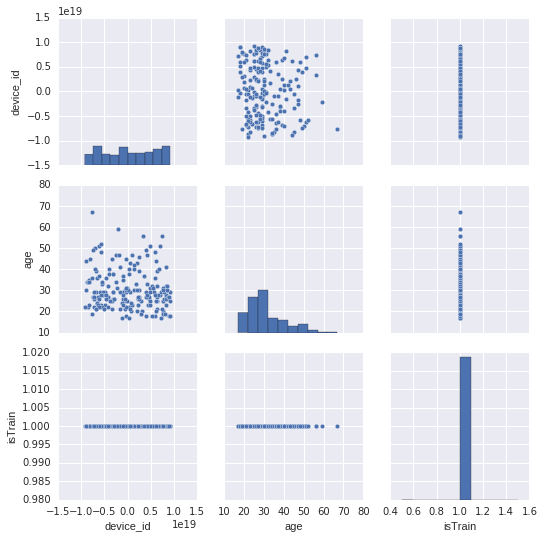

In [185]:
sns.pairplot(ga_train[ga_train.device_id.isin(tab.index)]);

No evident correlation here. Let's drop dublicates.

In [177]:
# Now we introduce a flag that clarifies which is the train and which is the test set.
# This is a paranoid new flag to split the data later on.
# We could probably also use age, gender, or group.

ga_train['isTrain']=1
ga_test['isTrain']=0
ga_test['age']=-1
ga_test['gender']='none'
ga_test['group']='none'
train_test = pd.concat([ga_train,ga_test])

In [199]:
showUniques(train_test)

Number of rows:  186716
Number of columns:  5
Number of unique values per column: 
Column age:  86
Column device_id:  186716
Column gender:  3
Column group:  13
Column isTrain:  2


No double entries in the train and test set.

In [206]:
phones = hardware.drop_duplicates('device_id',keep='last')
showUniques(phones) 

Number of rows:  186716
Number of columns:  3
Number of unique values per column: 
Column device_id:  186716
Column phone_brand:  131
Column device_model:  1599


This worked, so we can concatenate phones with the other data.

In [239]:
train_test.tail()

,age,device_id,gender,group,isTrain
186711,-1,4280900819321920929,none,none,0
186712,-1,818534825520551359,none,none,0
186713,-1,-8956851351560395765,none,none,0
186714,-1,6097318236795836256,none,none,0
186715,-1,622421180514002079,none,none,0


In [248]:
phones.index=list(range(0,len(phones)))
train_test.index=list(range(0,len(train_test)))
print(len(train_test), len(phones))
new = pd.merge(left=train_test,right=phones, left_on='device_id', right_on='device_id',how='outer')
print(len(new))


186716 186716
186716


In [289]:
# let us check if this worked fine
from utilities import printBumper
for i,id in enumerate(new.device_id):
    test_model = phones.device_model[phones.device_id==id].ravel()[0]
    new_model  = new[new.device_id==id].device_model.ravel()[0]
    test_brand = phones[phones.device_id==id].phone_brand.ravel()[0]
    new_brand  = new[new.device_id==id].phone_brand.ravel()[0]
    if not test_model==new_model:
        print("device model not correctly merged.") 
    if not test_brand==new_brand:
        print("phone brand not correctly merged")
    if i % 500 == 0:
        print(float(i)/len(new.device_id)*100, " % done.")
        print("x-check tests:")
        print(test_model, " == ", new_model, " ?? ")
        print(test_brand, " == ", new_brand, " ?? ")
        printBumper('next please')
#  if i > 1e3:
#      break

0.0  % done.
x-check tests:
MI 2  ==  MI 2  ?? 
小米  ==  小米  ?? 
next please 
0.2677863707448746  % done.
x-check tests:
Galaxy Note 3  ==  Galaxy Note 3  ?? 
三星  ==  三星  ?? 
next please 
0.5355727414897492  % done.
x-check tests:
MX4 Pro  ==  MX4 Pro  ?? 
魅族  ==  魅族  ?? 
next please 


#### This worked fine. 
Let's write this into a new data file. We can use this file to start a new notebook.

In [294]:
new.head(2)
new.to_csv(files_dir+"/traintest_phone.csv")